# Configurazione di Fabry Perot


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

_lambda = 632.8 * 10**(-9)

dati = pd.read_excel("Interferometro.xlsx")

# distanze in metri
#display(dati)
L_focale = 18 * 10**(-3)
distanza_lente_schermo = 1.605

distanza_eff = distanza_lente_schermo - L_focale
err_distanza_eff = 0.5*10**(-2)

raggi = dati["raggio"] * 10**(-2)
err_raggi = 1 * 10**(-3)

dfdx = 1/(1+(raggi/distanza_eff)**2)
part_r = 1/distanza_eff * dfdx
part_dist = -raggi/distanza_eff**2 * dfdx

angoli = np.arctan(raggi/distanza_eff)
err_angoli = np.sqrt((part_r*err_raggi)**2 + (part_dist*err_distanza_eff)**2)

y = 2*np.cos(angoli)/_lambda
err_y = 2*np.abs(np.sin(angoli))/_lambda*err_angoli

from iminuit import Minuit
from iminuit.cost import LeastSquares

def linear_cost(x, N_0, d):
    return N_0/d - x/d

x = [4,3,2,1,0]

def minimi_quadrati_fit(alfa, beta):
    minimi_quadrati = LeastSquares(x, y[alfa:beta], err_y[alfa:beta], linear_cost)

    m = Minuit(minimi_quadrati, N_0=16856, d=0.005)
    m.strategy = 2

    m.migrad()
    m.hesse()
    display(m)

    return m.values["d"], m.errors["d"], m.values["N_0"], m.errors["N_0"]


for i in range(0, 6):
    print(minimi_quadrati_fit(i*5, (i+1)*5))
    

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.9018 (χ²/ndof = 0.3)     │              Nfcn = 124              │
│ EDM = 1.7e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_0  │  16.62e3  │  0.07e3   │            │            │         │         │       │
│ 1 │ d    │ 5.258e-3  │ 0.021e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────┐
│     │          N_0            d │
├─────┼───────────────────────────┤
│ N_0 │     4.38e+03 1.3872382e-3 │
│   d │ 1.3872382e-3     4.39e-10 │
└─────┴───────────────────────────┘

(0.005257864900981252, 2.095147249207599e-05, 16617.16476832625, 66.21200069257594)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.7317 (χ²/ndof = 0.2)     │              Nfcn = 126              │
│ EDM = 1.18e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_0  │  16.86e3  │  0.07e3   │            │            │         │         │       │
│ 1 │ d    │ 5.335e-3  │ 0.022e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────┐
│     │          N_0            d │
├─────┼───────────────────────────┤
│ N_0 │     4.73e+03 1.4965745e-3 │
│   d │ 1.4965745e-3     4.74e-10 │
└─────┴───────────────────────────┘

(0.005334894313512948, 2.1761518167414477e-05, 16860.55761915804, 68.77163651956218)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.2514 (χ²/ndof = 0.1)     │              Nfcn = 124              │
│ EDM = 1.69e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_0  │  16.40e3  │  0.06e3   │            │            │         │         │       │
│ 1 │ d    │ 5.190e-3  │ 0.018e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────┐
│     │           N_0             d │
├─────┼─────────────────────────────┤
│ N_0 │      3.26e+03 1.03149103e-3 │
│   d │ 1.03149103e-3      3.26e-10 │
└─────┴─────────────────────────────┘

(0.005190017265999974, 1.8066201552699633e-05, 16402.943636513253, 57.0950967118844)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.5465 (χ²/ndof = 0.2)     │              Nfcn = 124              │
│ EDM = 2.12e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_0  │  16.63e3  │  0.06e3   │            │            │         │         │       │
│ 1 │ d    │ 5.261e-3  │ 0.020e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────┐
│     │          N_0            d │
├─────┼───────────────────────────┤
│ N_0 │      4.1e+03 1.2988007e-3 │
│   d │ 1.2988007e-3     4.11e-10 │
└─────┴───────────────────────────┘

(0.005260685399657158, 2.0272576265036447e-05, 16626.15163353651, 64.06691021303855)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.5465 (χ²/ndof = 0.2)     │              Nfcn = 124              │
│ EDM = 2.12e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_0  │  16.63e3  │  0.06e3   │            │            │         │         │       │
│ 1 │ d    │ 5.261e-3  │ 0.020e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────┐
│     │          N_0            d │
├─────┼───────────────────────────┤
│ N_0 │      4.1e+03 1.2988007e-3 │
│   d │ 1.2988007e-3     4.11e-10 │
└─────┴───────────────────────────┘

(0.005260685399657158, 2.0272576265036447e-05, 16626.15163353651, 64.06691021303855)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.04202 (χ²/ndof = 0.0)    │              Nfcn = 126              │
│ EDM = 1.34e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_0  │  16.84e3  │  0.07e3   │            │            │         │         │       │
│ 1 │ d    │ 5.330e-3  │ 0.021e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────┐
│     │          N_0            d │
├─────┼───────────────────────────┤
│ N_0 │     4.47e+03 1.4137204e-3 │
│   d │ 1.4137204e-3     4.47e-10 │
└─────┴───────────────────────────┘

(0.0053297734645734755, 2.1150498861327805e-05, 16844.435847373534, 66.84102693779033)


In [3]:
import pandas as pd

dati = pd.read_excel("Interferometro second.xlsx")
display(dati)


,L focale [mm],18,d [micrometri],n frange,raggio,Deltad eff [microm],DeltaN,DeltaN medio,Michelson,Unnamed: 9,Deltad eff m,DeltaN m
0,"d(lente,schermo) [cm]",160.5000,26,5.0,3.70,10.0,27.0,NaN,"d(lente,schermo) [cm]",167.8,10.0,29.0
1,lamda [microm],0.6328,26,NaN,3.30,NaN,32.0,NaN,NaN,NaN,NaN,33.0
2,NaN,NaN,26,NaN,2.90,NaN,29.0,NaN,NaN,NaN,NaN,28.0
3,NaN,NaN,26,NaN,2.20,NaN,30.0,NaN,NaN,NaN,NaN,29.0
4,NaN,NaN,26,NaN,1.35,NaN,29.0,NaN,NaN,NaN,NaN,31.0
5,NaN,NaN,46,NaN,3.70,7.0,19.0,NaN,NaN,NaN,7.0,22.0
6,NaN,NaN,46,NaN,3.30,NaN,22.0,NaN,NaN,NaN,NaN,21.0
7,NaN,NaN,46,NaN,2.90,NaN,20.0,NaN,NaN,NaN,NaN,18.0
8,NaN,NaN,46,NaN,2.25,NaN,20.0,NaN,NaN,NaN,NaN,21.0
9,NaN,NaN,46,NaN,1.40,NaN,21.0,NaN,NaN,NaN,NaN,20.0


In [4]:
delta_N = np.array(dati["DeltaN"])

def calcola_delta_d(nome_colonna):
    delta_N = np.array(dati[nome_colonna])

    # Calcola delta_d di ciascun set
    delta_d = []
    sigma_delta_d = []

    # Calcola la media di delta_N di ciascun set
    medie_delta_N = []
    sigma_delta_N = []

    # Calcola la media di ciascun set
    # Abbiamo 3 set di 5 valori
    for i in range(0, 3*5, 5):
        current_set = delta_N[i:i+5]

        media_set = np.mean(current_set)
        medie_delta_N.append(media_set)

        err_set = np.std(current_set) / np.sqrt(len(current_set)) # errore della media!
        sigma_delta_N.append(err_set)
    
    delta_d = np.array(medie_delta_N)*_lambda/2 
    sigma_delta_d = np.array(sigma_delta_N)*_lambda/2

    print(medie_delta_N, sigma_delta_N)

    return delta_d, sigma_delta_d

from scipy.stats import t

# test di ipotesi con t di student
def test_t_student(valore_atteso, valore_calcolato, errore, df, alfa=0.05):
    t_calcolato = np.abs(valore_calcolato - valore_atteso) / errore
    t_critico = t.ppf(1-alfa/2, df)
    print(f"t: {t_calcolato:.3} < t critico: {t_critico:.3} ? {t_calcolato < t_critico} \n")

def stampa_risultati(delta_d, sigma_delta_d, nome_aspettazione, alfa):
    for i in range(len(delta_d)):
        valore_atteso = dati[nome_aspettazione][i*5]*10**(-6)
        errore_micrometro = 0.25*10**(-6)
        valore_calcolato = delta_d[i]
        errore = np.sqrt(sigma_delta_d[i]**2 + errore_micrometro**2)

        print(f"Valore atteso: {valore_atteso:.2e} \nValore calcolato: {valore_calcolato:.2e} +- {errore:.2e} \n")

        test_t_student(valore_atteso, valore_calcolato, errore, 4, alfa)
        
delta_d, err_delta_d = calcola_delta_d("DeltaN")
stampa_risultati(delta_d, err_delta_d, "Deltad eff [microm]", 0.05)

[29.4, 20.4, 14.6] [0.7266360849833979, 0.4560701700396552, 0.35777087639996635]
Valore atteso: 1.00e-05 
Valore calcolato: 9.30e-06 +- 3.40e-07 

t: 2.05 < t critico: 2.78 ? True 

Valore atteso: 7.00e-06 
Valore calcolato: 6.45e-06 +- 2.89e-07 

t: 1.89 < t critico: 2.78 ? True 

Valore atteso: 5.00e-06 
Valore calcolato: 4.62e-06 +- 2.74e-07 

t: 1.39 < t critico: 2.78 ? True 



# Configurazione di Michelson

In [5]:
delta_d, err_delta_d = calcola_delta_d("DeltaN m")
stampa_risultati(delta_d, err_delta_d, "Deltad eff m", 0.05)

distanza_lente_schermo = 167.8 * 10**(-2) # metri

# il test è superato con cos(theta) circa 1 come assunzione!

dati_2 = pd.read_excel("Interferometro.xlsx")

#display(dati_2)


[30.0, 20.4, 15.4] [0.7999999999999999, 0.606630035524124, 0.4560701700396551]
Valore atteso: 1.00e-05 
Valore calcolato: 9.49e-06 +- 3.56e-07 

t: 1.43 < t critico: 2.78 ? True 

Valore atteso: 7.00e-06 
Valore calcolato: 6.45e-06 +- 3.15e-07 

t: 1.73 < t critico: 2.78 ? True 

Valore atteso: 5.00e-06 
Valore calcolato: 4.87e-06 +- 2.89e-07 

t: 0.441 < t critico: 2.78 ? True 



[0.05235988 0.08726646 0.03490659]
[ 7.2 21.2  3.2]
[0.43817804600413285, 0.33466401061363016, 0.17888543819998315]
[1.49734051 1.54243427 1.49762503]
[0.14896088 0.16750688 0.14903668]


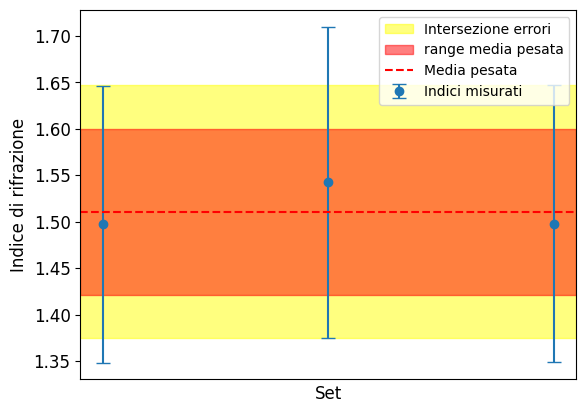

In [6]:
angolo_iniziale = 0 

_lambda = 632.8 * 10**(-9) # metri
d = 5*10**(-3) # metri, dovrebbe essere sulla scheda pasco, l'abbiamo misurata
err_d = 1 * 10**(-3) # metri

angoli = np.radians([3, 5, 2])
print(angoli)

delta_N = np.array(dati_2["deltaN v"])

# Calcola la media di delta_N di ciascun set
vec_medie_delta_N = []
sigma_delta_N = []

# Calcola la media di ciascun set
# Abbiamo 3 set di 5 valori
for i in range(0, 3*5, 5):
    current_delta_N = delta_N[i:i+5]

    media_delta_N = np.mean(current_delta_N )
    vec_medie_delta_N.append(media_delta_N)

    err_set = np.std(current_delta_N) / np.sqrt(len(current_delta_N)) # errore della media!
    sigma_delta_N.append(err_set) 

vec_medie_delta_N = np.array(vec_medie_delta_N)
n_vetro = (2*d-vec_medie_delta_N*_lambda)*(1-np.cos(angoli)) \
        / (2*d*(1-np.cos(angoli)) - vec_medie_delta_N*_lambda)

def calcola_n_vetro(d, delta_N, angolo):
    return (2*d-delta_N*_lambda)*(1-np.cos(angolo)) \
         / (2*d*(1-np.cos(angolo)) - delta_N*_lambda)

# define derivative function
def derivative(f, x, dx=1e-6, args=()):
    return (f(x+dx, *args) - f(x, *args))/dx

def dndN(d, delta_N, angolo):
    return derivative(calcola_n_vetro, delta_N, args=(d, angolo))

def dndangolo(d, delta_N, angolo):
    return derivative(calcola_n_vetro, angolo, args=(d, delta_N))

def dndd(d, delta_N, angolo):
    return derivative(calcola_n_vetro, d, args=(delta_N, angolo))

print(vec_medie_delta_N)
print(sigma_delta_N)

print(n_vetro)

err_n_vetro = np.sqrt((dndN(d, vec_medie_delta_N, angoli)*sigma_delta_N)**2 + (dndd(d, vec_medie_delta_N, angoli)*err_d)**2 + (dndangolo(d, vec_medie_delta_N, angoli)*np.radians(0.5))**2)
print(err_n_vetro)

def weighet_mean(vec_x, err_vec_x):
    return np.sum(vec_x/err_vec_x**2) / np.sum(1/err_vec_x**2), 1/np.sqrt(np.sum(1/err_vec_x**2))

media, errore_media = weighet_mean(n_vetro, err_n_vetro)

# disegna punti di n_vetro e barra errore e colora la zona di errore di media con errore_media
plt.errorbar(np.arange(3), n_vetro, yerr=err_n_vetro, fmt="o", label="Indici misurati", capsize=5)
plt.axhspan(n_vetro[2]+err_n_vetro[2], n_vetro[1]-err_n_vetro[1], alpha=0.5, color='yellow', label="Intersezione errori")
plt.axhspan(media+errore_media, media-errore_media, alpha=0.5, color='red', label="range media pesata")
# linea media tratteggiata
plt.axhline(media, color='red', linestyle="--", label="Media pesata")

# rimuovi asse x e dai un nome ad ogni punto
plt.xticks([])
plt.yticks(fontsize=12)
plt.ylabel("Indice di rifrazione", fontsize=12)
plt.xlabel("Set", fontsize=12)

plt.legend()
plt.show()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 75.43 (χ²/ndof = 25.1)     │              Nfcn = 18               │
│ EDM = 8.38e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lambda_ │  625e-9   │   4e-9    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────┐
│         │ lambda_ │
├─────────┼─────────┤
│ lambda_ │ 1.4e-17 │
└─────────┴─────────┘

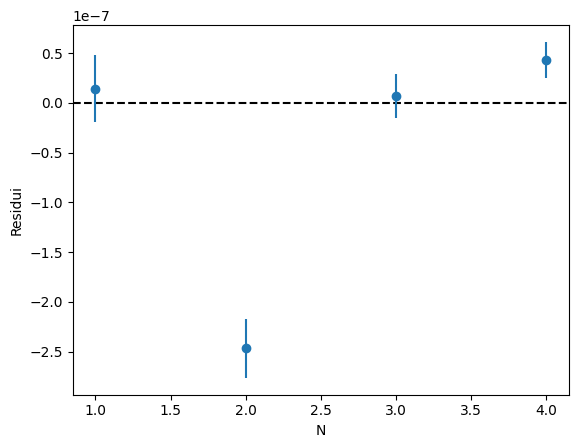

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.9616 (χ²/ndof = 0.5)     │              Nfcn = 18               │
│ EDM = 4.32e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lambda_ │  634e-9   │   4e-9    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────┐
│         │ lambda_ │
├─────────┼─────────┤
│ lambda_ │ 1.5e-17 │
└─────────┴─────────┘

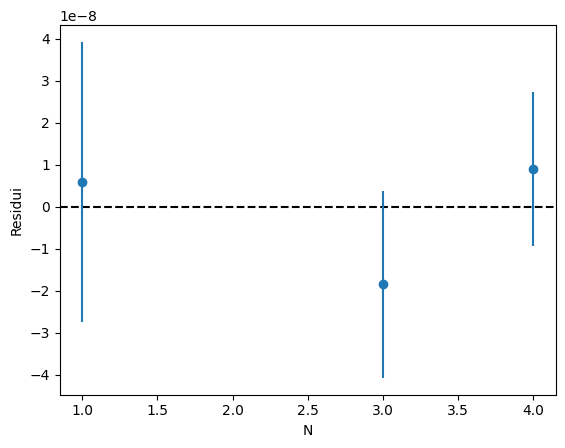

In [7]:
#passo righello
d = 10**(-3) # metri

d_Pt_P0 = 13.80 * 10**(-2)
err_d_Pt_P0 = 0.5 * 10**(-3)

D = 1.29
err_D = 1 * 10**(-2) # più grande visto che si usa il metro

# praticamente inutili
d_laser_righello = 2.29
err_d_laser_righello = 5 * 10**(-3)

d_P0_PN = np.array([1.4, 2.1, 3.6, 4.6]) * 10**(-2)
err_d_P0_PN = 1 * 10**(-3)

# L distanza tra P_0 e P_N
# l distanza tra Pt e P_0
L = d_P0_PN
l = d_Pt_P0
err_l = err_d_Pt_P0
err_L = err_d_P0_PN

# considero angoli piccoli
# arctan(x) = x
# cos(x) = 1 - x**2/2
theta_inc = l/(2*D)
theta_N = (L+l/2)/(D)

cos_theta_inc = 1-theta_inc**2/2
cos_theta_N = 1-theta_N**2/2

N = np.array([1, 2, 3, 4])
y = d * (cos_theta_inc - cos_theta_N)

# Propagazione errori fatta a mano
err_y = d/(2*D**2)*np.sqrt(((L*l-L**2)/D*err_D)**2+((l-2*L)*err_L)**2+(L*err_l)**2)
def model(x, lambda_):
    return lambda_*x

minimi_quadrati = LeastSquares(N, y, err_y, model)

m = Minuit(minimi_quadrati, lambda_=630*10**(-9))

m.migrad()
m.hesse()
display(m)
lambda_con_2 = m.values["lambda_"]
err_lambda_con_2 = m.errors["lambda_"]

def mostra_residui(N, y, err_y, model, x):
    residuals = y - model(N, x)
    plt.axhline(0, color="black", linestyle="--")
    plt.errorbar(N, residuals, yerr=err_y, fmt="o")
    plt.xlabel("N")
    plt.ylabel("Residui")
    plt.show()

mostra_residui(N, y, err_y, model, lambda_con_2)


# rimuovo secondo elemento (ha un valore anomalo)
y = np.delete(y, 1)
err_y = np.delete(err_y, 1)
N = np.delete(N, 1)

minimi_quadrati = LeastSquares(N, y, err_y, model)

m = Minuit(minimi_quadrati, lambda_=630*10**(-9))

m.migrad()
m.hesse()
display(m)
lambda_senza_2 = m.values["lambda_"]
err_lambda_senza_2 = m.errors["lambda_"]

mostra_residui(N, y, err_y, model, lambda_senza_2)

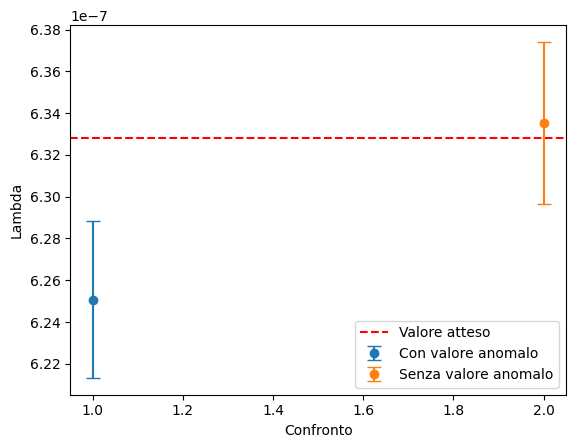

In [8]:
# confronta con lambda_con_2 e lambda_senza_2 con valore atteso, disegna una retta
# orizzontale per il valore vero e rappresenta lambda_con_2 e lambda_senza_2 con le loro barre d'errore e dei trattini che le delimitano

import matplotlib.pyplot as plt

plt.axhline(y=_lambda, color='r', linestyle='--', label="Valore atteso")
plt.errorbar(1, lambda_con_2, yerr=err_lambda_con_2, fmt="o", label="Con valore anomalo", capsize=5)
plt.errorbar(2, lambda_senza_2, yerr=err_lambda_senza_2, fmt="o", label="Senza valore anomalo", capsize=5)

plt.xlabel("Confronto")
plt.ylabel("Lambda")


#posiziona la legenda in basso a destra
plt.legend(loc="lower right")

# rendi più belle le barre di errore
plt.show()